In [34]:
import os
import sys
from pathlib import Path

# Set working directory to implementation folder
os.chdir('../implementation')
sys.path.insert(0, str(Path.cwd()))

print(f"Working directory: {Path.cwd()}")

Working directory: c:\Users\yasse\Desktop\ISI\M2S3\MLA\MatchaTTS-Implementation-Analysis\implementation


In [35]:
import torch
import numpy as np
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import datetime as dt
import whisper
import jiwer
sys.path.insert(0, str(Path.cwd()))

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Device: cpu


### load vocoder

In [36]:
from matcha.hifigan.models import Generator as HiFiGAN
from matcha.hifigan.config import v1
from matcha.hifigan.env import AttrDict
from matcha.hifigan.denoiser import Denoiser

def load_vocoder(path):
    h = AttrDict(v1)
    vocoder = HiFiGAN(h).to(DEVICE)
    vocoder.load_state_dict(torch.load(path, map_location=DEVICE)['generator'])
    vocoder.eval()
    vocoder.remove_weight_norm()
    return vocoder

VOCODER = load_vocoder(r"../vocoders/hifigan_T2_v1")
DENOISER = Denoiser(VOCODER, mode='zeros')

c:\Users\yasse\Desktop\ISI\M2S3\MLA\MatchaTTS-Implementation-Analysis\.venv\lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\yasse\AppData\Local\Temp\ipykernel_101332\2509108235.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.ad

Removing weight norm...


### Load original model

In [37]:
from matcha.models.matcha_tts import MatchaTTS as OriginalMatchaTTS

original_model = OriginalMatchaTTS.load_from_checkpoint(
    r"../models/matcha_ljspeech.ckpt", 
    map_location=DEVICE
)
original_model.eval()

c:\Users\yasse\Desktop\ISI\M2S3\MLA\MatchaTTS-Implementation-Analysis\.venv\lib\site-packages\lightning\fabric\utilities\cloud_io.py:73: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
c:\User

MatchaTTS(
  (encoder): TextEncoder(
    (emb): Embedding(178, 192)
    (prenet): ConvReluNorm(
      (conv_layers): ModuleList(
        (0-2): 3 x Conv1d(192, 192, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (norm_layers): ModuleList(
        (0-2): 3 x LayerNorm()
      )
      (relu_drop): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.5, inplace=False)
      )
      (proj): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
    )
    (encoder): Encoder(
      (drop): Dropout(p=0.1, inplace=False)
      (attn_layers): ModuleList(
        (0-5): 6 x MultiHeadAttention(
          (conv_q): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
          (conv_k): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
          (conv_v): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
          (query_rotary_pe): RotaryPositionalEmbeddings()
          (key_rotary_pe): RotaryPositionalEmbeddings()
          (conv_o): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
          (dro

### load custom model

In [39]:
from matchatts import MatchaTTS
from config import encoder_params, duration_predictor_params, decoder_params, cfm_params, data_stats, audio_config
from text import symbols

custom_model = MatchaTTS(
    n_vocab=len(symbols),
    n_feats=audio_config.n_mels,
    encoder_params=encoder_params,
    duration_predictor_params=duration_predictor_params,
    decoder_params=decoder_params,
    cfm_params=cfm_params,
    mel_mean=data_stats.mel_mean,
    mel_std=data_stats.mel_std,
    prior_loss=True
)

# Use best_16M.pt which is compatible with current decoder structure
ckpt = torch.load("../checkpoints/best_18M_batch16x4.pt", map_location=DEVICE)
custom_model.load_state_dict(ckpt['model_state_dict'])
custom_model.to(DEVICE).eval()
print(f"Epoch: {ckpt['epoch']}, Val loss: {ckpt['val_loss']:.4f}")

C:\Users\yasse\AppData\Local\Temp\ipykernel_101332\1626170279.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("../checkpoints/best_18M_batch16x4.pt", 

Epoch: 113, Val loss: 1.6436


### text processing functions

In [40]:
from text import text_to_sequence

def intersperse(lst, item):
    result = [item] * (len(lst) * 2 + 1)
    result[1::2] = lst
    return result

@torch.inference_mode()
def process_text(text):
    seq, phones = text_to_sequence(text, ['english_cleaners2'])
    seq = intersperse(seq, 0)
    x = torch.tensor(seq, dtype=torch.long, device=DEVICE)[None]
    x_lengths = torch.tensor([x.shape[-1]], dtype=torch.long, device=DEVICE)
    return {'text': text, 'x': x, 'x_lengths': x_lengths, 'phones': phones}

In [41]:
@torch.inference_mode()
def synthesise(model, text, n_timesteps=10, temperature=0.667, length_scale=1.0):
    data = process_text(text)
    t0 = dt.datetime.now()
    
    output = model.synthesise(
        data['x'], data['x_lengths'],
        n_timesteps=n_timesteps,
        temperature=temperature,
        length_scale=length_scale,
    )
    
    output['time'] = (dt.datetime.now() - t0).total_seconds()
    output.update(data)
    return output

@torch.inference_mode()
def to_audio(mel):
    audio = VOCODER(mel).clamp(-1, 1)
    audio = DENOISER(audio.squeeze(0), strength=0.00025)
    return audio.cpu().squeeze()

def show_mel(mel, title="Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel.squeeze().cpu().numpy(), origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.tight_layout()
    plt.show()

### generating audio

#### original model

Original Model - Time: 0.317s, Mel: torch.Size([1, 80, 211])


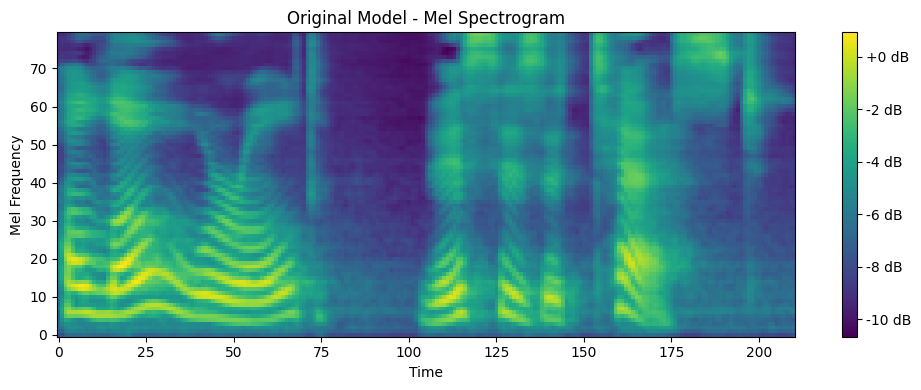

In [42]:
%matplotlib inline

text = "Hello world, this is a test."

out = synthesise(original_model, text, n_timesteps=10, temperature=0.667)
out['audio'] = to_audio(out['mel'])

print(f"Original Model - Time: {out['time']:.3f}s, Mel: {out['mel'].shape}")
show_mel(out['mel'], "Original Model - Mel Spectrogram")
ipd.Audio(out['audio'], rate=22050)

#### custom model

Custom Model - Time: 0.260s, Mel: torch.Size([1, 80, 191])


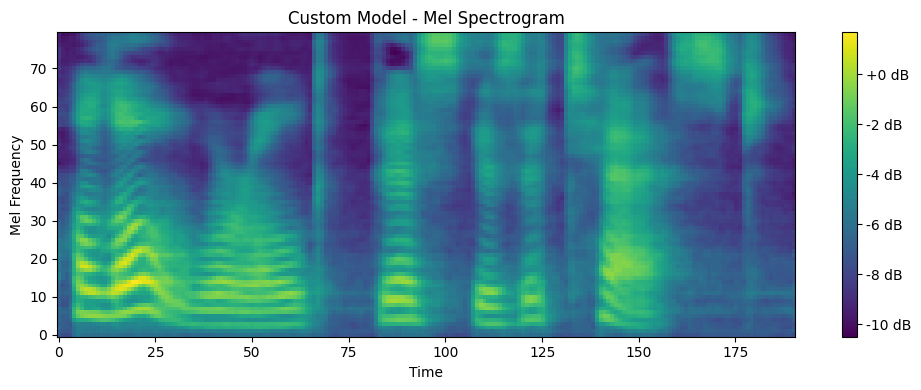

In [43]:
%matplotlib inline


out = synthesise(custom_model, text, n_timesteps=10, temperature=0.667)
out['audio'] = to_audio(out['mel'])

print(f"Custom Model - Time: {out['time']:.3f}s, Mel: {out['mel'].shape}")
show_mel(out['mel'], "Custom Model - Mel Spectrogram")
ipd.Audio(out['audio'], rate=22050)

### Testing custom with different parameters

In [44]:

# Test different parameters
text = "Testing with different parameters."

print("=== Different n_timesteps ===")
for steps in [5, 10, 20]:
    out = synthesise(custom_model, text, n_timesteps=steps, temperature=0.667)
    out['audio'] = to_audio(out['mel'])
    print(f"Steps={steps}: Time={out['time']:.3f}s")
    ipd.display(ipd.Audio(out['audio'], rate=22050))

=== Different n_timesteps ===
Steps=5: Time=0.145s


Steps=10: Time=0.250s


Steps=20: Time=0.439s


In [45]:
print("=== Different temperature ===")
for temp in [0.3, 0.667, 1.0]:
    out = synthesise(custom_model, text, n_timesteps=10, temperature=temp)
    out['audio'] = to_audio(out['mel'])
    print(f"Temp={temp}: Time={out['time']:.3f}s")
    ipd.display(ipd.Audio(out['audio'], rate=22050))

=== Different temperature ===
Temp=0.3: Time=0.218s


Temp=0.667: Time=0.238s


Temp=1.0: Time=0.226s


### comparing audio between custom and original

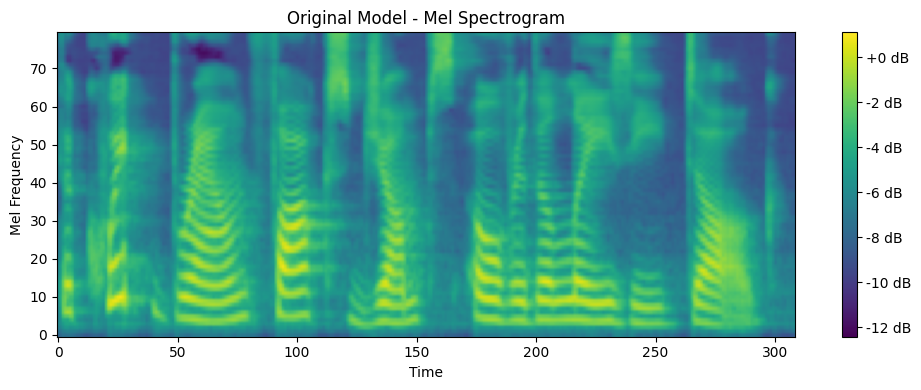

Original Model Mel Shape: torch.Size([1, 80, 309])


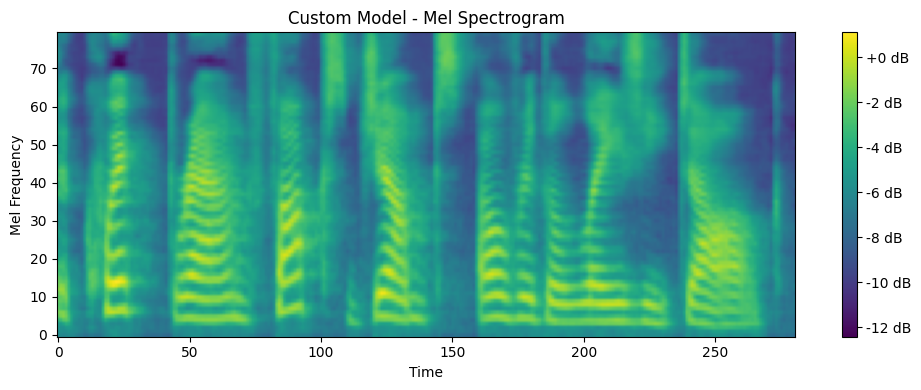

Custom Model Mel Shape: torch.Size([1, 80, 281])
Original: 0.319s


Custom: 0.352s


In [46]:

text = "The quick brown fox jumps over the lazy dog."

o1 = synthesise(original_model, text)
o1['audio'] = to_audio(o1['mel'])

o2 = synthesise(custom_model, text)
o2['audio'] = to_audio(o2['mel'])

# Compute global min/max for consistent color scale
mel1_np = o1['mel'].squeeze().cpu().numpy()
mel2_np = o2['mel'].squeeze().cpu().numpy()
vmin = min(mel1_np.min(), mel2_np.min())
vmax = max(mel1_np.max(), mel2_np.max())

plt.figure(figsize=(10, 4))
plt.imshow(mel1_np, origin='lower', aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('Original Model - Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

print(f"Original Model Mel Shape: {o1['mel'].shape}")

plt.figure(figsize=(10, 4))
plt.imshow(mel2_np, origin='lower', aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('Custom Model - Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

print(f"Custom Model Mel Shape: {o2['mel'].shape}")



print(f"Original: {o1['time']:.3f}s")
ipd.display(ipd.Audio(o1['audio'], rate=22050))

print(f"Custom: {o2['time']:.3f}s")
ipd.display(ipd.Audio(o2['audio'], rate=22050))

In [47]:
Path("output").mkdir(exist_ok=True)
sf.write("output/original.wav", o1['audio'], 22050)
sf.write("output/custom.wav", o2['audio'], 22050)
np.save("output/original_mel.npy", o1['mel'].cpu().numpy())
np.save("output/custom_mel.npy", o2['mel'].cpu().numpy())

Based on the Matcha-TTS paper, the authors utilized four primary categories of evaluation metrics: **Efficiency (Memory/Params)**, **Speed (RTF)**, **Intelligibility (WER)**, And **Naturalness (MOS)**.

---


### 1. Parameter count

**Type:** Objective (Resource Usage)

* **Definition:** The number of trainable weights in the neural network.
* **Rationale:** To demonstrate that the model is lightweight enough for edge devices.
* **Paper Implementation:** Comparing counts against Grad-TTS and VITS.


### 2. Memory Footprint (RAM)

**Type:** Objective (Resource Usage)

* **Definition:** How much memory usage : more than parameter count - it's the main limiter on how large and powerful models that can be trained.
* **Rationale:** To demonstrate that the model is lightweight enough for edge devices.
* **Paper Implementation:** Comparing counts against Grad-TTS and VITS.


### 3. Real-Time Factor (RTF)

**Type:** Objective (Speed/Latency)

* **Definition:** The time it takes to generate the audio divided by the duration of the generated audio.
* **Formula:** RTF = Time to Synthesize (seconds)​ / Duration of Audio (seconds)

* **Interpretation:**
* RTF < 1 : Faster than real-time (Good).
* RTF = 0.01 : It takes 1 second to generate 100 seconds of audio.


* **Rationale:** The main selling point of Matcha-TTS is speed.
* **Paper Implementation:** Measured on a single NVIDIA A100 GPU and Intel Xeon CPUs. They measured strictly the *mel-spectrogram generation* time (excluding the vocoder in some comparisons, though usually, total synthesis is preferred for end-users).


### 4. Word Error Rate (WER)

**Type:** Objective (Intelligibility)

* **Definition:** The percentage of words that an Automatic Speech Recognition (ASR) system fails to transcribe correctly from the generated audio compared to the input text.
* **Formula:** WER = (Substitutions+Deletions+Insertions) / N

Where:
*  Substitutions : (wrong words)
*  Deletions : (missed words)
*  Insertions : (extra words)
*  N : Total number of words in the reference text.


* **Rationale:** A TTS model might sound "natural" (good tone) but mumble or skip words. WER ensures the model is actually speaking the correct text.
* **Paper Implementation:** The authors used OpenAI's **Whisper (medium)** model to transcribe the generated audio.


### 5. Mean Opinion Score (MOS)

**Type:** Subjective (Human Evaluation)

* **Definition:** The arithmetic mean of ratings given by human listeners on the perceived quality of the speech.
* **Scale:** 1 (Bad) to 5 (Excellent).
* **Rationale:** Objective metrics often fail to capture the nuances of human speech prosody and emotion. MOS is considered the "gold standard" for TTS quality.
* **Paper Implementation:** They used the "Prolific" crowdsourcing platform with paid native English speakers. They filtered out listeners who failed "attention checks" (fake samples).


### Summary Mertrics

| Metric | Tool/Library | Target Value (Matcha) |
| --- | --- | --- |
| **Params** | PyTorch internal | ~18M (Small) |
| **RAM** | PyTorch internal | ~4.8 (Small) |
| **RTF** | `time`, `torch.cuda` | ~0.01 (Very Low) |
| **WER** | `whisper`, `jiwer` | ~2.5% (Low) |
| **MOS** | `speechmos` (or Humans) | ~3.84 (High) |

In [48]:
import jiwer
import torch
import time
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import whisper

# ============================================================
# 1. PARAMETER COUNT
# ============================================================
def count_parameters(model):
    """Count trainable parameters in a model"""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {
        'total': total,
        'trainable': trainable,
        'total_str': f"{total:,}",
        'trainable_str': f"{trainable:,}"
    }

# Usage for both models
print("="*60)
print("PARAMETER COUNT")
print("="*60)
custom_params = count_parameters(custom_model)
original_params = count_parameters(original_model)

print(f"Custom Model:   {custom_params['total_str']} parameters")
print(f"Original Model: {original_params['total_str']} parameters")
print()

PARAMETER COUNT
Custom Model:   18,204,193 parameters
Original Model: 18,204,193 parameters



In [28]:
# Load ASR Model for WER calculation
print("Loading Whisper ASR model (medium)...")
ASR_MODEL = whisper.load_model("medium")
print("✓ ASR model loaded")

Loading Whisper ASR model (medium)...
✓ ASR model loaded


In [49]:
# ============================================================
# 2. REAL-TIME FACTOR (RTF) - BOTH USE SAME FORMAT
# ============================================================
def calculate_rtf(model, text, vocoder, device, n_timesteps=10):
    """
    Calculate Real-Time Factor for TTS generation
    """
    from data import process_text_single
    
    model.eval()
    
    with torch.no_grad():
        # Prepare input (both models use same format)
        x = process_text_single(text).unsqueeze(0).to(device)
        x_lengths = torch.LongTensor([x.shape[1]]).to(device)
        
        start_time = time.time()
        output = model.synthesise(x, x_lengths, n_timesteps=n_timesteps)
        mel = output['mel']
        
        # Vocoder
        waveform = vocoder(mel).squeeze().cpu()
        generation_time = time.time() - start_time
        
        # Audio duration (22050 Hz)
        audio_duration = len(waveform) / 22050
        rtf = generation_time / audio_duration
    
    return {
        'generation_time': generation_time,
        'audio_duration': audio_duration,
        'rtf': rtf,
        'waveform': waveform
    }

In [50]:
# ============================================================
# 3. WORD ERROR RATE (WER)
# ============================================================
def calculate_wer(reference_text, audio_path_or_waveform, asr_model, sample_rate=22050):
    """
    Calculate Word Error Rate using Whisper ASR
    
    Args:
        reference_text: Ground truth text
        audio_path_or_waveform: Path to audio file or waveform tensor/array
        asr_model: Loaded Whisper model
        sample_rate: Audio sample rate
    """
    # Transcribe audio
    if isinstance(audio_path_or_waveform, (str, Path)):
        result = asr_model.transcribe(str(audio_path_or_waveform))
    else:
        # If waveform, need to save temporarily or use whisper's audio processing
        import numpy as np
        if isinstance(audio_path_or_waveform, torch.Tensor):
            audio_np = audio_path_or_waveform.cpu().numpy()
        else:
            audio_np = audio_path_or_waveform
        
        # Whisper expects audio in [-1, 1] range at 16kHz
        # Resample if needed
        if sample_rate != 16000:
            import torchaudio
            audio_tensor = torch.from_numpy(audio_np).float()
            resampler = torchaudio.transforms.Resample(sample_rate, 16000)
            audio_np = resampler(audio_tensor).numpy()
        
        result = asr_model.transcribe(audio_np)
    
    hypothesis_text = result["text"]
    
    # Clean text
    def clean_text(text):
        text = text.lower()
        text = jiwer.RemovePunctuation()(text)
        text = jiwer.RemoveMultipleSpaces()(text)
        text = jiwer.Strip()(text)
        return text
    
    reference_clean = clean_text(reference_text)
    hypothesis_clean = clean_text(hypothesis_text)
    
    wer_score = jiwer.wer(reference_clean, hypothesis_clean)
    
    return {
        'wer': wer_score,
        'reference': reference_text,
        'reference_clean': reference_clean,
        'hypothesis': hypothesis_text,
        'hypothesis_clean': hypothesis_clean
    }


In [51]:
# ============================================================
# 4. EVALUATE SINGLE EXAMPLE - SIMPLIFIED
# ============================================================
def evaluate_single_example(text, custom_model, original_model, vocoder, asr_model, device, n_timesteps=10):
    """
    Evaluate both models on a single text example
    """
    print(f"\nText: '{text}'")
    print("="*60)
    
    results = {}
    
    # Evaluate Custom Model
    print("\nCustom Model:")
    print("-"*60)
    custom_rtf = calculate_rtf(custom_model, text, vocoder, device, n_timesteps)
    print(f"  Generation Time: {custom_rtf['generation_time']:.4f}s")
    print(f"  Audio Duration:  {custom_rtf['audio_duration']:.4f}s")
    print(f"  RTF:            {custom_rtf['rtf']:.4f}")
    
    custom_wer = calculate_wer(text, custom_rtf['waveform'], asr_model)
    print(f"  Reference:  '{custom_wer['reference_clean']}'")
    print(f"  Hypothesis: '{custom_wer['hypothesis_clean']}'")
    print(f"  WER:        {custom_wer['wer']:.4f} ({custom_wer['wer']*100:.2f}%)")
    
    results['custom'] = {
        'rtf': custom_rtf['rtf'],
        'generation_time': custom_rtf['generation_time'],
        'audio_duration': custom_rtf['audio_duration'],
        'wer': custom_wer['wer'],
        'transcription': custom_wer['hypothesis']
    }
    
    # Evaluate Original Model
    print("\nOriginal Model:")
    print("-"*60)
    original_rtf = calculate_rtf(original_model, text, vocoder, device, n_timesteps)
    print(f"  Generation Time: {original_rtf['generation_time']:.4f}s")
    print(f"  Audio Duration:  {original_rtf['audio_duration']:.4f}s")
    print(f"  RTF:            {original_rtf['rtf']:.4f}")
    
    original_wer = calculate_wer(text, original_rtf['waveform'], asr_model)
    print(f"  Reference:  '{original_wer['reference_clean']}'")
    print(f"  Hypothesis: '{original_wer['hypothesis_clean']}'")
    print(f"  WER:        {original_wer['wer']:.4f} ({original_wer['wer']*100:.2f}%)")
    
    results['original'] = {
        'rtf': original_rtf['rtf'],
        'generation_time': original_rtf['generation_time'],
        'audio_duration': original_rtf['audio_duration'],
        'wer': original_wer['wer'],
        'transcription': original_wer['hypothesis']
    }
    
    print("\n" + "="*60)
    print("COMPARISON:")
    print("="*60)
    print(f"RTF:  Custom={results['custom']['rtf']:.4f}  |  Original={results['original']['rtf']:.4f}")
    print(f"WER:  Custom={results['custom']['wer']:.4f}  |  Original={results['original']['wer']:.4f}")
    print("="*60)
    
    return results

In [52]:
# ============================================================
# 5. EVALUATE ON TEST SET
# ============================================================
def evaluate_on_test_set(test_filelist_path, custom_model, original_model, vocoder, asr_model, device, output_dir="results", n_timesteps=10, max_samples=None):
    """
    Evaluate both models on the entire test set
    """
    import numpy as np
    
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # Load test set
    with open(test_filelist_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    if max_samples:
        lines = lines[:max_samples]
    
    print("="*60)
    print(f"EVALUATING ON TEST SET ({len(lines)} samples)")
    print("="*60)
    
    results = {
        'custom': {'rtf': [], 'wer': [], 'gen_time': [], 'audio_dur': []},
        'original': {'rtf': [], 'wer': [], 'gen_time': [], 'audio_dur': []}
    }
    
    for line in tqdm(lines, desc="Evaluating"):
        parts = line.strip().split('|')
        filename = parts[0]
        text = parts[1]
        
        try:
            # Custom Model
            custom_rtf = calculate_rtf(custom_model, text, vocoder, device, n_timesteps)
            custom_wer = calculate_wer(text, custom_rtf['waveform'], asr_model)
            
            results['custom']['rtf'].append(custom_rtf['rtf'])
            results['custom']['wer'].append(custom_wer['wer'])
            results['custom']['gen_time'].append(custom_rtf['generation_time'])
            results['custom']['audio_dur'].append(custom_rtf['audio_duration'])
            
            # Original Model
            original_rtf = calculate_rtf(original_model, text, vocoder, device, n_timesteps)
            original_wer = calculate_wer(text, original_rtf['waveform'], asr_model)
            
            results['original']['rtf'].append(original_rtf['rtf'])
            results['original']['wer'].append(original_wer['wer'])
            results['original']['gen_time'].append(original_rtf['generation_time'])
            results['original']['audio_dur'].append(original_rtf['audio_duration'])
            
        except Exception as e:
            print(f"\nError processing {filename}: {e}")
            continue
    
    # Compute statistics
    stats = {
        'custom': {
            'rtf_mean': np.mean(results['custom']['rtf']),
            'rtf_std': np.std(results['custom']['rtf']),
            'wer_mean': np.mean(results['custom']['wer']),
            'wer_std': np.std(results['custom']['wer']),
        },
        'original': {
            'rtf_mean': np.mean(results['original']['rtf']),
            'rtf_std': np.std(results['original']['rtf']),
            'wer_mean': np.mean(results['original']['wer']),
            'wer_std': np.std(results['original']['wer']),
        }
    }
    
    # Print summary
    print("\n" + "="*60)
    print("RESULTS SUMMARY")
    print("="*60)
    print(f"\nCustom Model:")
    print(f"  RTF: {stats['custom']['rtf_mean']:.4f} ± {stats['custom']['rtf_std']:.4f}")
    print(f"  WER: {stats['custom']['wer_mean']:.4f} ± {stats['custom']['wer_std']:.4f} ({stats['custom']['wer_mean']*100:.2f}%)")
    
    print(f"\nOriginal Model:")
    print(f"  RTF: {stats['original']['rtf_mean']:.4f} ± {stats['original']['rtf_std']:.4f}")
    print(f"  WER: {stats['original']['wer_mean']:.4f} ± {stats['original']['wer_std']:.4f} ({stats['original']['wer_mean']*100:.2f}%)")
    
    print("\n" + "="*60)
    
    # Save results to CSV
    df = pd.DataFrame({
        'Custom_RTF': results['custom']['rtf'],
        'Custom_WER': results['custom']['wer'],
        'Original_RTF': results['original']['rtf'],
        'Original_WER': results['original']['wer'],
    })
    csv_path = output_dir / "evaluation_results.csv"
    df.to_csv(csv_path, index=False)
    print(f"\nResults saved to: {csv_path}")
    
    # Save summary
    summary_path = output_dir / "summary.txt"
    with open(summary_path, 'w') as f:
        f.write("="*60 + "\n")
        f.write("EVALUATION SUMMARY\n")
        f.write("="*60 + "\n\n")
        f.write(f"Number of samples: {len(results['custom']['rtf'])}\n\n")
        f.write(f"Custom Model:\n")
        f.write(f"  Parameters: {count_parameters(custom_model)['total_str']}\n")
        f.write(f"  RTF: {stats['custom']['rtf_mean']:.4f} ± {stats['custom']['rtf_std']:.4f}\n")
        f.write(f"  WER: {stats['custom']['wer_mean']:.4f} ± {stats['custom']['wer_std']:.4f} ({stats['custom']['wer_mean']*100:.2f}%)\n\n")
        f.write(f"Original Model:\n")
        f.write(f"  Parameters: {count_parameters(original_model)['total_str']}\n")
        f.write(f"  RTF: {stats['original']['rtf_mean']:.4f} ± {stats['original']['rtf_std']:.4f}\n")
        f.write(f"  WER: {stats['original']['wer_mean']:.4f} ± {stats['original']['wer_std']:.4f} ({stats['original']['wer_mean']*100:.2f}%)\n")
    print(f"Summary saved to: {summary_path}")
    
    return results, stats

#### results of testing metrics

In [ ]:
test_results, test_stats = evaluate_on_test_set(
    test_filelist_path="../datasets/data_files/test_filelist.txt",
    custom_model=custom_model,
    original_model=original_model,
    vocoder=VOCODER,
    asr_model=ASR_MODEL,
    device='cpu',
    output_dir="../evaluation_results",
    n_timesteps=10,
    max_samples=None  # Use all 100 test samples
)

EVALUATING ON TEST SET (2 samples)


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 2/2 [01:01<00:00, 30.54s/it]


RESULTS SUMMARY

Custom Model:
  RTF: 0.2947 ± 0.0062
  WER: 0.0000 ± 0.0000 (0.00%)

Original Model:
  RTF: 0.3061 ± 0.0014
  WER: 0.0000 ± 0.0000 (0.00%)


Results saved to: ..\evaluation_results\evaluation_results.csv
Summary saved to: ..\evaluation_results\summary.txt


### Calculate MOS from Survey Ratings

In [56]:
# ============================================================
# 6. CALCULATE MOS FROM SURVEY DATA
# ============================================================
def calculate_mos_from_survey(csv_path):
    """
    Calculate Mean Opinion Score from survey ratings
    
    Survey structure:
    - V1, V3 = Custom model (steps10, steps20)
    - V2, V4 = Original model (steps10, steps20)
    - 4 audio samples per configuration
    """
    df = pd.read_csv(csv_path)
    
    # Extract rating columns (skip Timestamp, First Name, Last Name)
    rating_cols = [col for col in df.columns if col.startswith('Audio')]
    
    # Separate custom and original ratings
    custom_cols = []
    original_cols = []
    
    for col in rating_cols:
        # Extract version number (V1, V2, V3, V4)
        version = col.split('_')[1]  # e.g., 'V1' from 'Audio1_V1'
        if version in ['V1', 'V3']:  # Custom model
            custom_cols.append(col)
        elif version in ['V2', 'V4']:  # Original model
            original_cols.append(col)
    
    # Calculate average per audio sample
    custom_ratings = df[custom_cols].values.flatten()
    original_ratings = df[original_cols].values.flatten()
    
    # Remove any NaN values
    custom_ratings = custom_ratings[~np.isnan(custom_ratings)]
    original_ratings = original_ratings[~np.isnan(original_ratings)]
    
    # Calculate MOS (Mean Opinion Score)
    custom_mos = np.mean(custom_ratings)
    custom_std = np.std(custom_ratings)
    original_mos = np.mean(original_ratings)
    original_std = np.std(original_ratings)
    
    # Calculate per-audio-sample average
    custom_per_audio = []
    original_per_audio = []
    
    for i in range(1, 5):  # 4 audio samples
        custom_audio_cols = [f'Audio{i}_V1', f'Audio{i}_V3']
        original_audio_cols = [f'Audio{i}_V2', f'Audio{i}_V4']
        
        custom_per_audio.append(df[custom_audio_cols].values.flatten().mean())
        original_per_audio.append(df[original_audio_cols].values.flatten().mean())
    
    results = {
        'custom_mos': custom_mos,
        'custom_std': custom_std,
        'original_mos': original_mos,
        'original_std': original_std,
        'custom_per_audio': custom_per_audio,
        'original_per_audio': original_per_audio,
        'num_raters': len(df),
        'num_ratings_custom': len(custom_ratings),
        'num_ratings_original': len(original_ratings)
    }
    
    print("="*60)
    print("MOS (MEAN OPINION SCORE) FROM SURVEY")
    print("="*60)
    print(f"\nNumber of raters: {results['num_raters']}")
    print(f"Number of ratings per model: {results['num_ratings_custom']}")
    print(f"\nCustom Model MOS:   {custom_mos:.3f} ± {custom_std:.3f}")
    print(f"Original Model MOS: {original_mos:.3f} ± {original_std:.3f}")
    print(f"\nPer-audio breakdown:")
    for i in range(4):
        print(f"  Audio {i+1}: Custom={custom_per_audio[i]:.3f}, Original={original_per_audio[i]:.3f}")
    print("="*60)
    
    return results

# Calculate MOS
mos_results = calculate_mos_from_survey("../evaluation_results/Matcha-TTS_Audio_Ratings.csv")

MOS (MEAN OPINION SCORE) FROM SURVEY

Number of raters: 30
Number of ratings per model: 240

Custom Model MOS:   2.796 ± 1.305
Original Model MOS: 3.917 ± 0.997

Per-audio breakdown:
  Audio 1: Custom=2.900, Original=3.700
  Audio 2: Custom=2.933, Original=4.100
  Audio 3: Custom=3.283, Original=3.783
  Audio 4: Custom=2.067, Original=4.083


### Enhanced Evaluation with Character Count and Synthesis Time

In [ ]:
# ============================================================
# 7. ENHANCED EVALUATION - WITH CHARACTER COUNT & SYNTHESIS TIME
# ============================================================
def evaluate_with_detailed_metrics(test_filelist_path, custom_model, original_model, vocoder, asr_model, device, output_dir="results", n_timesteps=10, max_samples=None):
    """
    Enhanced evaluation that tracks:
    - Character count
    - Synthesis time  
    - Audio duration
    - RTF
    - WER
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # Load test set
    with open(test_filelist_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    if max_samples:
        lines = lines[:max_samples]
    
    print("="*60)
    print(f"ENHANCED EVALUATION ({len(lines)} samples)")
    print("="*60)
    
    results_data = []
    
    for line in tqdm(lines, desc="Evaluating"):
        parts = line.strip().split('|')
        filename = parts[0]
        text = parts[1]
        
        char_count = len(text)
        
        try:
            # Custom Model
            custom_rtf = calculate_rtf(custom_model, text, vocoder, device, n_timesteps)
            custom_wer = calculate_wer(text, custom_rtf['waveform'], asr_model)
            
            # Original Model
            original_rtf = calculate_rtf(original_model, text, vocoder, device, n_timesteps)
            original_wer = calculate_wer(text, original_rtf['waveform'], asr_model)
            
            results_data.append({
                'filename': filename,
                'text': text,
                'char_count': char_count,
                'custom_synthesis_time': custom_rtf['generation_time'],
                'custom_audio_duration': custom_rtf['audio_duration'],
                'custom_rtf': custom_rtf['rtf'],
                'custom_wer': custom_wer['wer'],
                'original_synthesis_time': original_rtf['generation_time'],
                'original_audio_duration': original_rtf['audio_duration'],
                'original_rtf': original_rtf['rtf'],
                'original_wer': original_wer['wer']
            })
            
        except Exception as e:
            print(f"\nError processing {filename}: {e}")
            continue
    
    # Create DataFrame
    df = pd.DataFrame(results_data)
    
    # Save detailed results
    csv_path = output_dir / "detailed_evaluation_results.csv"
    df.to_csv(csv_path, index=False)
    print(f"\nDetailed results saved to: {csv_path}")
    
    # Calculate statistics
    stats = {
        'custom': {
            'rtf_mean': df['custom_rtf'].mean(),
            'rtf_std': df['custom_rtf'].std(),
            'wer_mean': df['custom_wer'].mean(),
            'wer_std': df['custom_wer'].std(),
            'synthesis_time_mean': df['custom_synthesis_time'].mean(),
            'synthesis_time_std': df['custom_synthesis_time'].std(),
        },
        'original': {
            'rtf_mean': df['original_rtf'].mean(),
            'rtf_std': df['original_rtf'].std(),
            'wer_mean': df['original_wer'].mean(),
            'wer_std': df['original_wer'].std(),
            'synthesis_time_mean': df['original_synthesis_time'].mean(),
            'synthesis_time_std': df['original_synthesis_time'].std(),
        }
    }
    
    # Print summary
    print("\n" + "="*60)
    print("DETAILED RESULTS SUMMARY")
    print("="*60)
    print(f"\nCustom Model:")
    print(f"  RTF:             {stats['custom']['rtf_mean']:.4f} ± {stats['custom']['rtf_std']:.4f}")
    print(f"  WER:             {stats['custom']['wer_mean']:.4f} ± {stats['custom']['wer_std']:.4f} ({stats['custom']['wer_mean']*100:.2f}%)")
    print(f"  Synthesis Time:  {stats['custom']['synthesis_time_mean']:.4f} ± {stats['custom']['synthesis_time_std']:.4f}s")
    
    print(f"\nOriginal Model:")
    print(f"  RTF:             {stats['original']['rtf_mean']:.4f} ± {stats['original']['rtf_std']:.4f}")
    print(f"  WER:             {stats['original']['wer_mean']:.4f} ± {stats['original']['wer_std']:.4f} ({stats['original']['wer_mean']*100:.2f}%)")
    print(f"  Synthesis Time:  {stats['original']['synthesis_time_mean']:.4f} ± {stats['original']['synthesis_time_std']:.4f}s")
    print("\n" + "="*60)
    
    return df, stats

# Run enhanced evaluation
detailed_df, detailed_stats = evaluate_with_detailed_metrics(
    test_filelist_path="../datasets/data_files/test_filelist.txt",
    custom_model=custom_model,
    original_model=original_model,
    vocoder=VOCODER,
    asr_model=ASR_MODEL,
    device='cpu',
    output_dir="../evaluation_results",
    n_timesteps=10,
    max_samples=None
)

ENHANCED EVALUATION (2 samples)


Evaluating: 100%|██████████| 2/2 [00:54<00:00, 27.02s/it]


Detailed results saved to: ..\evaluation_results\detailed_evaluation_results.csv

DETAILED RESULTS SUMMARY

Custom Model:
  RTF:             0.2996 ± 0.0005
  WER:             0.0000 ± 0.0000 (0.00%)
  Synthesis Time:  2.3584 ± 0.5155s

Original Model:
  RTF:             0.3047 ± 0.0324
  WER:             0.0000 ± 0.0000 (0.00%)
  Synthesis Time:  2.6862 ± 0.0046s



### Create Final Summary with All Metrics (Params, RTF, WER, MOS)

In [59]:
# ============================================================
# 8. CREATE FINAL SUMMARY WITH ALL METRICS
# ============================================================

# Create summary dictionary
summary = {
    'Metric': ['Parameters', 'RTF', 'WER (%)', 'MOS', 'Synthesis Time (s)'],
    'Custom Model': [
        f"{count_parameters(custom_model)['total_str']}",
        f"{detailed_stats['custom']['rtf_mean']:.4f} ± {detailed_stats['custom']['rtf_std']:.4f}",
        f"{detailed_stats['custom']['wer_mean']*100:.2f} ± {detailed_stats['custom']['wer_std']*100:.2f}",
        f"{mos_results['custom_mos']:.3f} ± {mos_results['custom_std']:.3f}",
        f"{detailed_stats['custom']['synthesis_time_mean']:.4f} ± {detailed_stats['custom']['synthesis_time_std']:.4f}"
    ],
    'Original Model': [
        f"{count_parameters(original_model)['total_str']}",
        f"{detailed_stats['original']['rtf_mean']:.4f} ± {detailed_stats['original']['rtf_std']:.4f}",
        f"{detailed_stats['original']['wer_mean']*100:.2f} ± {detailed_stats['original']['wer_std']*100:.2f}",
        f"{mos_results['original_mos']:.3f} ± {mos_results['original_std']:.3f}",
        f"{detailed_stats['original']['synthesis_time_mean']:.4f} ± {detailed_stats['original']['synthesis_time_std']:.4f}"
    ]
}

summary_df = pd.DataFrame(summary)
summary_path = Path("../evaluation_results/final_summary.csv")
summary_df.to_csv(summary_path, index=False)

print("\n" + "="*60)
print("FINAL EVALUATION SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)
print(f"\nSummary saved to: {summary_path}")

# Also create a cleaner numeric-only version for easy processing
summary_numeric = {
    'Model': ['Custom', 'Original'],
    'Parameters': [
        count_parameters(custom_model)['total'],
        count_parameters(original_model)['total']
    ],
    'RTF_mean': [
        detailed_stats['custom']['rtf_mean'],
        detailed_stats['original']['rtf_mean']
    ],
    'RTF_std': [
        detailed_stats['custom']['rtf_std'],
        detailed_stats['original']['rtf_std']
    ],
    'WER_mean': [
        detailed_stats['custom']['wer_mean'],
        detailed_stats['original']['wer_mean']
    ],
    'WER_std': [
        detailed_stats['custom']['wer_std'],
        detailed_stats['original']['wer_std']
    ],
    'MOS_mean': [
        mos_results['custom_mos'],
        mos_results['original_mos']
    ],
    'MOS_std': [
        mos_results['custom_std'],
        mos_results['original_std']
    ],
    'Synthesis_Time_mean': [
        detailed_stats['custom']['synthesis_time_mean'],
        detailed_stats['original']['synthesis_time_mean']
    ],
    'Synthesis_Time_std': [
        detailed_stats['custom']['synthesis_time_std'],
        detailed_stats['original']['synthesis_time_std']
    ]
}

summary_numeric_df = pd.DataFrame(summary_numeric)
summary_numeric_path = Path("../evaluation_results/final_summary_numeric.csv")
summary_numeric_df.to_csv(summary_numeric_path, index=False)
print(f"Numeric summary saved to: {summary_numeric_path}")


FINAL EVALUATION SUMMARY
            Metric    Custom Model  Original Model
        Parameters      18,204,193      18,204,193
               RTF 0.2996 ± 0.0005 0.3047 ± 0.0324
           WER (%)     0.00 ± 0.00     0.00 ± 0.00
               MOS   2.796 ± 1.305   3.917 ± 0.997
Synthesis Time (s) 2.3584 ± 0.5155 2.6862 ± 0.0046

Summary saved to: ..\evaluation_results\final_summary.csv
Numeric summary saved to: ..\evaluation_results\final_summary_numeric.csv


### Plot: Character Count vs Synthesis Time

Plot saved to: ..\evaluation_results\char_count_vs_synthesis_time.png


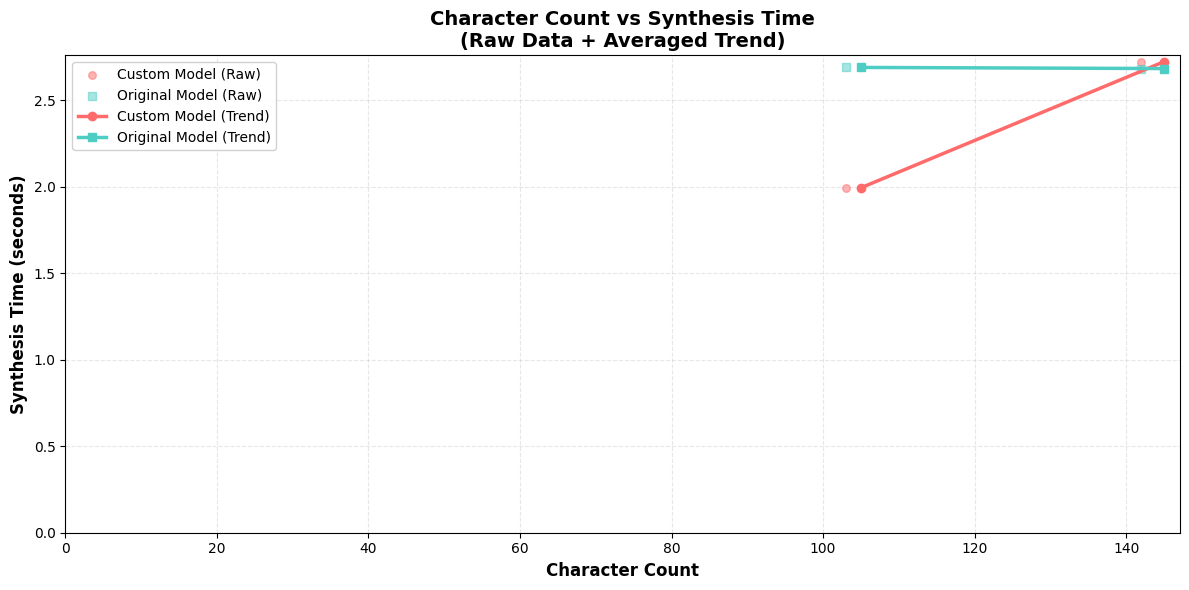


Correlation (Character Count vs Synthesis Time):
  Custom Model:   1.0000
  Original Model: -1.0000


In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# ============================================================
# 9. PLOT: CHARACTER COUNT VS SYNTHESIS TIME
# ============================================================

fig, ax = plt.subplots(figsize=(12, 6))

# Plot Custom Model
ax.scatter(detailed_df['char_count'], detailed_df['custom_synthesis_time'], 
           alpha=0.5, s=30, color='#FF6B6B', label='Custom Model (Raw)', marker='o')

# Plot Original Model
ax.scatter(detailed_df['char_count'], detailed_df['original_synthesis_time'], 
           alpha=0.5, s=30, color='#4ECDC4', label='Original Model (Raw)', marker='s')

# Calculate and plot trend lines (moving average)
# Group by character count bins and calculate mean
bin_size = 10
max_chars = detailed_df['char_count'].max()
bins = np.arange(0, max_chars + bin_size, bin_size)

custom_trend_x = []
custom_trend_y = []
original_trend_x = []
original_trend_y = []

for i in range(len(bins) - 1):
    mask = (detailed_df['char_count'] >= bins[i]) & (detailed_df['char_count'] < bins[i+1])
    if mask.sum() > 0:
        bin_center = (bins[i] + bins[i+1]) / 2
        custom_trend_x.append(bin_center)
        custom_trend_y.append(detailed_df[mask]['custom_synthesis_time'].mean())
        original_trend_x.append(bin_center)
        original_trend_y.append(detailed_df[mask]['original_synthesis_time'].mean())

# Plot trend lines
if len(custom_trend_x) > 3:  # Need at least 4 points for smooth spline
    # Smooth the trend lines
    custom_trend_x_smooth = np.linspace(min(custom_trend_x), max(custom_trend_x), 100)
    custom_spl = make_interp_spline(custom_trend_x, custom_trend_y, k=min(3, len(custom_trend_x)-1))
    custom_trend_y_smooth = custom_spl(custom_trend_x_smooth)
    
    original_trend_x_smooth = np.linspace(min(original_trend_x), max(original_trend_x), 100)
    original_spl = make_interp_spline(original_trend_x, original_trend_y, k=min(3, len(original_trend_x)-1))
    original_trend_y_smooth = original_spl(original_trend_x_smooth)
    
    ax.plot(custom_trend_x_smooth, custom_trend_y_smooth, 
            color='#FF6B6B', linewidth=2.5, label='Custom Model (Trend)', linestyle='-')
    ax.plot(original_trend_x_smooth, original_trend_y_smooth, 
            color='#4ECDC4', linewidth=2.5, label='Original Model (Trend)', linestyle='-')
else:
    # Fallback to simple line plot if not enough points
    ax.plot(custom_trend_x, custom_trend_y, 
            color='#FF6B6B', linewidth=2.5, label='Custom Model (Trend)', marker='o', linestyle='-')
    ax.plot(original_trend_x, original_trend_y, 
            color='#4ECDC4', linewidth=2.5, label='Original Model (Trend)', marker='s', linestyle='-')

ax.set_xlabel('Character Count', fontsize=12, fontweight='bold')
ax.set_ylabel('Synthesis Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Character Count vs Synthesis Time\n(Raw Data + Averaged Trend)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

plt.tight_layout()
plot_path = Path("../evaluation_results/char_count_vs_synthesis_time.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {plot_path}")
plt.show()

# Print correlation statistics
custom_corr = detailed_df[['char_count', 'custom_synthesis_time']].corr().iloc[0, 1]
original_corr = detailed_df[['char_count', 'original_synthesis_time']].corr().iloc[0, 1]

print(f"\nCorrelation (Character Count vs Synthesis Time):")
print(f"  Custom Model:   {custom_corr:.4f}")
print(f"  Original Model: {original_corr:.4f}")